In [3]:
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib
#!pip install statsmodels
#!pip install scipy

Привет, Арам! Инициализирую оценку А/В теста...
Изучаю датасет...
Датасет состоит из 49811 строк и 8 столбцов

Преобразовываю столбец с датой и временем.
Столбец Sessions имеет более одного уникального значения
Преобразовываю датафрейм для оценки статистики по каждому пользователю...(ожидаю завершения)
Преобразование завершено.
Теперь датасет состоит из 21949 строк и 9 столбцов

Данные представлены за период с 2023-04-11 по 2023-04-25
Тест проводился 14 дней.

Даты начала тестов для групп А и B совпадают.
Даты окончания тестов для групп А и B совпадают.

Оценим сбалансированность групп А и B.
Данные в группах А и В сбалансированы.



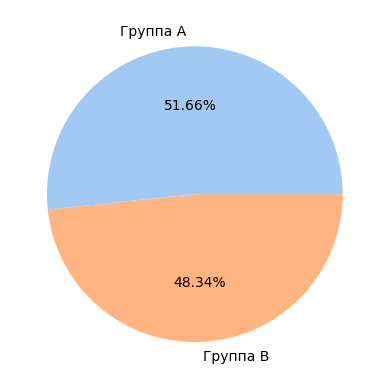

Оценим конверсию по группам.
Конверсия группы В изменилась по отношению к группе А изменилась на -0.0018 или на -20.64%
   Variant  count_visits  count_successes  conversion  conversion_%
0        0         11339              101    0.008907      0.890731
1        1         10610               75    0.007069      0.706880

Оценим изменение кумулятивной конверсии по дням.


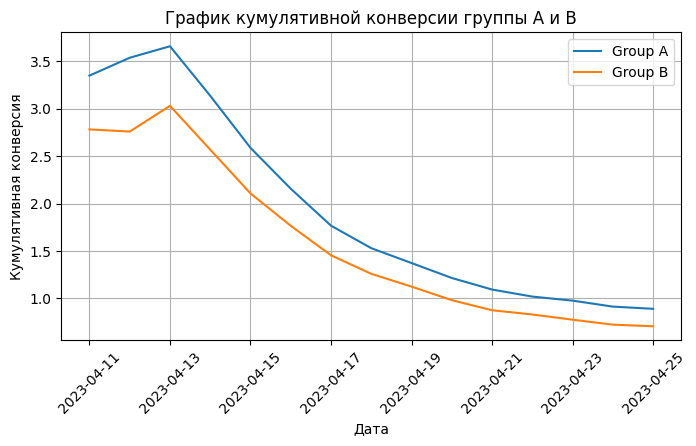


Теперь перейдем к проверке статистической значимости метрик в обеих группах.
Уровень значимости установлен 0.05
Нулевая гипотеза: конверсии в группах А и B равны
Альтернативная гипотеза: конверсии в группах А и В не равны
p-value:  0.13
Принимаем нулевую гипотезу. Конверсии в группах А и B равны

Теперь убедимся в правильности выводов и построим 95% доверительный интервал.
Доверительный интервал группы А: (0.0072, 0.0106)
Доверительный интервал группы B: (0.0055, 0.0087)

Также построим доверительный интервал для разности конверсий.
Доверительный интервал для разности конверсий: (-0.0042, 0.0005)
Отличия статистически значимые: False

Воспользуемся бутстрепом.
Оценим конверсии и найдем доверительные интервалы для разниц конверсий, сгенерировав 10000 подвыборок.
Бутстреп в работе... (ожидаю завершения)
Оценка завершена.
Значение конверсии изменилось на: -0.002
95% доверительный интервал для разности конверсий с бустрепом: (-0.0042, 0.0005)
Отличия статистически значимые: False

Построи

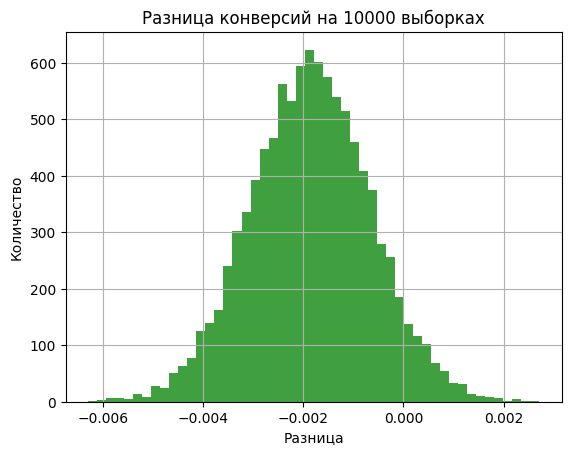

Отчет завершен. Спасибо.


In [42]:
import pandas as pd # работа с таблицами
import numpy as np # линейная алгебра
import seaborn as sns # графики и диаграммы
import matplotlib.pyplot as plt # графики и диаграммы
from statsmodels.stats.proportion import proportions_ztest # статистические тесты
from scipy.stats import norm # статистика
%matplotlib inline

csv_file = 'data/GA export for AB - as (5).csv' # "Введите путь к CSV файлу (например, 'data/file.csv')
user_col = 'Sessions' # Введите название столбца с пользователями
group_col = 'Variant' # Введите название столбца с двумя тестовыми группами
result_col = 'ga:goal14Completions' # Введите название столбца с целевой метрикой
date_col = 'Date Hour and Minute' # Введите название столбца с датой

data = pd.read_csv(csv_file)

print('Привет, Арам! Инициализирую оценку А/В теста...')
print('Изучаю датасет...')
print(f'Датасет состоит из {data.shape[0]} строк и {data.shape[1]} столбцов')
print()

print('Преобразовываю столбец с датой и временем.')
data[date_col] = pd.to_datetime(
    data[date_col], 
    format='%Y%m%d%H%M'
    )
data['date'] = pd.to_datetime(
    data[date_col]).dt.date

def optimize_users(df, users_col, goal_col):
    new_rows = []
    for index, row in df.iterrows():
        # Check for invalid values of Users and Goal
        if row[users_col] < 0 or row[goal_col] < 0:
            continue
        if row[users_col] == 0 and row[goal_col] == 0:
            continue
        if row[users_col] > 1 and row[goal_col] == 0:
            for i in range(row[users_col]):
                new_row = row.copy()
                new_row[users_col] = 1
                new_row[goal_col] = 0
                new_rows.append(new_row)
        elif row[users_col] == 0 and row[goal_col] > 1:
            for i in range(row[goal_col]):
                new_row = row.copy()
                new_row[users_col] = 0
                new_row[goal_col] = 1
                new_rows.append(new_row)
        elif row[users_col] == 0 and row[goal_col] == 1:
            new_rows.append(row)
        elif row[users_col] == 1 and row[goal_col] == 0:
            new_rows.append(row)
        elif row[users_col] == 1 and row[goal_col] == 1:
            new_rows.append(row)
        elif row[users_col] == 0 and row[goal_col] > 1:
            for i in range(row[goal_col]):
                new_row = row.copy()
                new_row[users_col] = 0
                new_row[goal_col] = 1
                new_rows.append(new_row)
        elif row[users_col] == 1 and row[goal_col] > 1:
            for i in range(row[goal_col]):
                new_row = row.copy()
                new_row[users_col] = 1
                new_row[goal_col] = 1
                new_rows.append(new_row)
            for i in range(row[users_col] - row[goal_col]):
                new_row = row.copy()
                new_row[users_col] = 1
                new_row[goal_col] = 0
                new_rows.append(new_row)
        elif row[users_col] > 1 and row[goal_col] == 1:
            for i in range(row[users_col] - row[goal_col]):
                new_row = row.copy()
                new_row[users_col] = 1
                new_row[goal_col] = 0
                new_rows.append(new_row) 
            for i in range(row[goal_col]):
                new_row = row.copy()
                new_row[users_col] = 1
                new_row[goal_col] = 1
                new_rows.append(new_row)       
        elif row[users_col] > 1 and row[goal_col] > 1:
            for i in range(row[goal_col]):
                new_row = row.copy()
                new_row[users_col] = 1
                new_row[goal_col] = 1
                new_rows.append(new_row)
            for i in range(row[users_col] - row[goal_col]):
                new_row = row.copy()
                new_row[users_col] = 1
                new_row[goal_col] = 0
                new_rows.append(new_row)
        else:
            raise ValueError("Invalid combination of Users and Goal values")
    new_df = pd.DataFrame(new_rows)
    return new_df

def optimize_users_2(df, variant_col, users_col, goal_col):
    groups = df.groupby(variant_col)
    new_rows = []
    for group in groups:
        variant_value = group[0]
        group_df = group[1]
        zero_one_rows = group_df[(group_df[users_col]==0) & (group_df[goal_col]==1)]
        one_zero_rows = group_df[(group_df[users_col]==1) & (group_df[goal_col]==0)]
        x = len(zero_one_rows)
        if x > 0:
            new_zero_one_rows = zero_one_rows.copy()
            new_zero_one_rows[users_col] = 1
            new_zero_one_rows[goal_col] = 1
            new_rows.append(new_zero_one_rows)
            one_zero_rows = one_zero_rows.iloc[x:]
        new_rows.append(one_zero_rows)
    new_df = pd.concat(new_rows, ignore_index=True)
    return new_df

if data[user_col].value_counts().shape[0] > 1:
    print(f'Столбец {user_col} имеет более одного уникального значения')
    print('Преобразовываю датафрейм для оценки статистики по каждому пользователю...(ожидаю завершения)')
    data = optimize_users(data, user_col, result_col)
    data = optimize_users_2(data, group_col, user_col, result_col)
    print('Преобразование завершено.')
    print(f'Теперь датасет состоит из {data.shape[0]} строк и {data.shape[1]} столбцов')
else:
    print(f'Столбец {user_col} имеет только одно уникальное значение.')
    print('Преобразование датафрейма не требуется.')
print()

print(f"Данные представлены за период с {data['date'].min()} по {data['date'].max()}")
print(f"Тест проводился {(data['date'].max() - data['date'].min()).days} дней.")

print()
if (data[data[group_col] == 0]['date'].min()-data[data[group_col] == 1]['date'].min()).days == 0:
    print("Даты начала тестов для групп А и B совпадают.")
else:
    print("ВНИМАНИЕ! Даты начала тестов для групп А и B не совпадают.")
    print(f"Дата начала теста группы А - {data[data[group_col] == 0]['date'].min()}")
    print(f"Дата начала теста группы B - {data[data[group_col] == 1]['date'].min()}")
    print("ВНИМАНИЕ! Для корректности оценки результатов А/В теста рекомендуется привести данные по группам к единой дате.")

if (data[data[group_col] == 0]['date'].max()-data[data[group_col] == 1]['date'].max()).days == 0:
    print("Даты окончания тестов для групп А и B совпадают.")
else:
    print("ВНИМАНИЕ! Даты окончания тестов для групп А и B не совпадают.")
    print(f"Дата окончания теста группы А - {data[data[group_col] == 0]['date'].max()}")
    print(f"Дата окончания теста группы B - {data[data[group_col] == 1]['date'].max()}")
    print("ВНИМАНИЕ! Для корректности оценки результатов А/В теста рекомендуется привести данные по группам к единой дате.")
print()
    
print("Оценим сбалансированность групп А и B.")
if data[data[group_col] == 0].shape[0] >= data[data[group_col] == 1].shape[0]:
    if data[data[group_col] == 1].shape[0] / data[data[group_col] == 0].shape[0] > 0.9:
        print("Данные в группах А и В сбалансированы.")
    else:
        print("ВНИМАНИЕ! Данные в группах А и В не сбалансированы. Результаты теста могут быть ошибочными.")
else:
    if data[data[group_col] == 0].shape[0] / data[data[group_col] == 1].shape[0] > 0.9:
        print("Данные в группах А и В сбалансированы.")
    else:
        print("ВНИМАНИЕ! Данные в группах А и В не сбалансированы. Результаты теста могут быть ошибочными.")

print()
values = [data[data[group_col] == 0].shape[0], data[data[group_col] == 1].shape[0]]
colors = sns.color_palette('pastel')
#create pie chart
plt.pie(values, labels=['Группа А', 'Группа В'], colors = colors, autopct='%.2f%%')
plt.show();
    
print("Оценим конверсию по группам.")
data_grouped = data.groupby(group_col).agg({
    user_col:'count',
    result_col:'sum'
}).reset_index().rename(columns={
    user_col: 'count_visits',
    result_col: 'count_successes'
})
data_grouped['conversion'] = data_grouped['count_successes'] / data_grouped['count_visits']
data_grouped['conversion_%'] = data_grouped['count_successes'] / data_grouped['count_visits'] * 100
data_grouped['conversion'] = data_grouped['count_successes'] / data_grouped['count_visits']
conv_a = data_grouped.loc[0, 'conversion']
conv_b = data_grouped.loc[1, 'conversion']
print(f'Конверсия группы В изменилась по отношению к группе А изменилась на {round(conv_b-conv_a, 4)} или на {round(conv_b/conv_a*100-100, 2)}%')
print(data_grouped)


data_grouped_cum = data.groupby(['date', group_col]).agg({
    user_col:'count',
    result_col:'sum'
}).reset_index().rename(columns={
    user_col: 'count_visits',
    result_col: 'count_successes'
})
data_grouped_cum['conversion_%'] = data_grouped_cum['count_successes'] / data_grouped_cum['count_visits'] * 100
data_grouped_cum['cum_count_visits'] = data_grouped_cum.groupby(
    [group_col])['count_visits'].cumsum()
data_grouped_cum['cum_count_successes'] = data_grouped_cum.groupby(
    [group_col])['count_successes'].cumsum()
data_grouped_cum['cum_conversion_%'] = data_grouped_cum['cum_count_successes'] / data_grouped_cum['cum_count_visits'] * 100
print()

print('Оценим изменение кумулятивной конверсии по дням.')
fig1, ax1 = plt.subplots(figsize=[8, 4])
ax1.plot(data_grouped_cum[data_grouped_cum[group_col] == 0]['date'], 
        data_grouped_cum[data_grouped_cum[group_col] == 0]['cum_conversion_%'], 
        label='Group A')
ax1.plot(data_grouped_cum[data_grouped_cum[group_col] == 1]['date'], 
        data_grouped_cum[data_grouped_cum[group_col] == 1]['cum_conversion_%'], 
        label='Group B')
ax1.set_title('График кумулятивной конверсии группы А и В')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Кумулятивная конверсия')
plt.xticks(rotation=45)
ax1.legend()
ax1.grid(True);
plt.show()

print()
print('Теперь перейдем к проверке статистической значимости метрик в обеих группах.')
print('Уровень значимости установлен 0.05')

H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсии в группах А и В не равны'
alpha = 0.05
print('Нулевая гипотеза: конверсии в группах А и B равны')
print('Альтернативная гипотеза: конверсии в группах А и В не равны')




_, p_value = proportions_ztest(
    count=data_grouped['count_successes'],
    nobs=data_grouped['count_visits'], 
    alternative='two-sided'
)

print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
print()
print("Теперь убедимся в правильности выводов и построим 95% доверительный интервал.")
group_a = data[data[group_col] == 0]
group_b = data[data[group_col] == 1]
def z_mean_conf_interval(n, x_mean, x_std, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * x_std / n**0.5 # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    return lower_bound, upper_bound

lower_bound_a, upper_bound_a = z_mean_conf_interval(
    group_a.shape[0], 
    group_a[result_col].mean(),
    group_a[result_col].std()
    )
# возвращаем кортеж из округлённых границ интервала для группы А
confidence_interval_a = (round(lower_bound_a, 4), round(upper_bound_a, 4))

lower_bound_b, upper_bound_b = z_mean_conf_interval(
    group_b.shape[0], 
    group_b[result_col].mean(),
    group_b[result_col].std()
    )
# возвращаем кортеж из округлённых границ интервала для группы В
confidence_interval_b = (round(lower_bound_b, 4), round(upper_bound_b, 4))

print(f'Доверительный интервал группы А: {confidence_interval_a}')
print(f'Доверительный интервал группы B: {confidence_interval_b}')
print()
print('Также построим доверительный интервал для разности конверсий.')
def diff_proportions_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound, 4), round(upper_bound, 4)

# размеры выборок групп А и B
n = [group_a.shape[0], group_b.shape[0]]
# выборочная пропорция групп A и B
x_p = [group_a[result_col].mean(), group_b[result_col].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, x_p)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
has_effect = not (diff_inverval[0] < 0 < diff_inverval[1])
print(f'Отличия статистически значимые: {has_effect}')
print()
print('Воспользуемся бутстрепом.')
print('Оценим конверсии и найдем доверительные интервалы для разниц конверсий, сгенерировав 10000 подвыборок.')
print('Бутстреп в работе... (ожидаю завершения)')
conversion_a = [] # создадим пустой список, куда будем вносить значения конверсии А
conversion_b = [] # создадим пустой список, куда будем вносить значения конверсии В
conversion_diffs = [] # создадим пустой список, куда будем вносить значения разности

for _ in range(10000): # запускаем цикл на 10000 итераций
    # создаем подвыборку для группы А с таким же размером
    sample_a = np.random.binomial(
        1, 
        group_a[result_col].mean(), 
        group_a.shape[0]
        )
    # создаем подвыборку для группы В с таким же размером
    sample_b = np.random.binomial(
        1, 
        group_b[result_col].mean(), 
        group_b.shape[0]
        )
    sample_a_mean = sample_a.mean() # считаем конверсию группы А
    sample_b_mean = sample_b.mean() # считаем конверсию группы B
    conversion_a.append(sample_a_mean) # сохраняем в список
    conversion_b.append(sample_b_mean) # сохраняем в список
    # находим разницу конверсий и добавляем ее в список
    conversion_diffs.append(sample_b_mean - sample_a_mean)
    
# размеры выборок групп А и B
n_bt = [group_a.shape[0], group_b.shape[0]]
# выборочная пропорция групп A и B
x_p_bt = [np.average(conversion_a), np.average(conversion_b)]
# строим доверительный интервал для разности конверсий
diff_inverval_bt = diff_proportions_conf_interval(n_bt, x_p_bt)
has_effect_bt = not (diff_inverval_bt[0] < 0 < diff_inverval_bt[1])

print("Оценка завершена.")
print(f'Значение конверсии изменилось на: {(np.average(conversion_diffs)):0.3f}')
print(f'95% доверительный интервал для разности конверсий с бустрепом: ({diff_inverval_bt[0]}, {diff_inverval_bt[1]})')
print(f'Отличия статистически значимые: {has_effect_bt}')
print()
print('Построим гистограмму распределения разницы конверсий')

plt.hist(x=conversion_diffs, bins=50, facecolor='g', alpha=0.75)
plt.grid(True)
plt.xlabel('Разница')
plt.ylabel('Количество')
plt.title('Разница конверсий на 10000 выборках')
plt.show();
print('Отчет завершен. Спасибо.')
